In [1]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib as mpl
import numpy as np
from matplotlib import cm
from matplotlib import pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import (
    MaxAbsScaler,
    MinMaxScaler,
    Normalizer,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
    minmax_scale,
)

dataset = fetch_california_housing()
X_full, y_full = dataset.data, dataset.target
feature_names = dataset.feature_names

feature_mapping = {
    "MedInc": "Median income in block",
    "HouseAge": "Median house age in block",
    "AveRooms": "Average number of rooms",
    "AveBedrms": "Average number of bedrooms",
    "Population": "Block population",
    "AveOccup": "Average house occupancy",
    "Latitude": "House block latitude",
    "Longitude": "House block longitude",
}

# Take only 2 features to make visualization easier
# Feature MedInc has a long tail distribution.
# Feature AveOccup has a few but very large outliers.
features = ["MedInc", "AveOccup"]
features_idx = [feature_names.index(feature) for feature in features]
X = X_full[:, features_idx]
distributions = [
    ("Unscaled data", X),
    ("Data after standard scaling", StandardScaler().fit_transform(X)),
    ("Data after min-max scaling", MinMaxScaler().fit_transform(X)),
    ("Data after max-abs scaling", MaxAbsScaler().fit_transform(X)),
    (
        "Data after robust scaling",
        RobustScaler(quantile_range=(25, 75)).fit_transform(X),
    ),
    (
        "Data after power transformation (Yeo-Johnson)",
        PowerTransformer(method="yeo-johnson").fit_transform(X),
    ),
    (
        "Data after power transformation (Box-Cox)",
        PowerTransformer(method="box-cox").fit_transform(X),
    ),
    (
        "Data after quantile transformation (uniform pdf)",
        QuantileTransformer(
            output_distribution="uniform", random_state=42
        ).fit_transform(X),
    ),
    (
        "Data after quantile transformation (gaussian pdf)",
        QuantileTransformer(
            output_distribution="normal", random_state=42
        ).fit_transform(X),
    ),
    ("Data after sample-wise L2 normalizing", Normalizer().fit_transform(X)),
]

# scale the output between 0 and 1 for the colorbar
y = minmax_scale(y_full)

# plasma does not exist in matplotlib < 1.5
cmap = getattr(cm, "plasma_r", cm.hot_r)


def create_axes(title, figsize=(16, 6)):
    fig = plt.figure(figsize=figsize)
    fig.suptitle(title)

    # define the axis for the first plot
    left, width = 0.1, 0.22
    bottom, height = 0.1, 0.7
    bottom_h = height + 0.15
    left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.1]
    rect_histy = [left_h, bottom, 0.05, height]

    ax_scatter = plt.axes(rect_scatter)
    ax_histx = plt.axes(rect_histx)
    ax_histy = plt.axes(rect_histy)

    # define the axis for the zoomed-in plot
    left = width + left + 0.2
    left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.1]
    rect_histy = [left_h, bottom, 0.05, height]

    ax_scatter_zoom = plt.axes(rect_scatter)
    ax_histx_zoom = plt.axes(rect_histx)
    ax_histy_zoom = plt.axes(rect_histy)

    # define the axis for the colorbar
    left, width = width + left + 0.13, 0.01

    rect_colorbar = [left, bottom, width, height]
    ax_colorbar = plt.axes(rect_colorbar)

    return (
        (ax_scatter, ax_histy, ax_histx),
        (ax_scatter_zoom, ax_histy_zoom, ax_histx_zoom),
        ax_colorbar,
    )


def plot_distribution(axes, X, y, hist_nbins=50, title="", x0_label="", x1_label=""):
    ax, hist_X1, hist_X0 = axes

    ax.set_title(title)
    ax.set_xlabel(x0_label)
    ax.set_ylabel(x1_label)

    # The scatter plot
    colors = cmap(y)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.5, marker="o", s=5, lw=0, c=colors)

    # Removing the top and the right spine for aesthetics
    # make nice axis layout
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))

    # Histogram for axis X1 (feature 5)
    hist_X1.set_ylim(ax.get_ylim())
    hist_X1.hist(
        X[:, 1], bins=hist_nbins, orientation="horizontal", color="grey", ec="grey"
    )
    hist_X1.axis("off")

    # Histogram for axis X0 (feature 0)
    hist_X0.set_xlim(ax.get_xlim())
    hist_X0.hist(
        X[:, 0], bins=hist_nbins, orientation="vertical", color="grey", ec="grey"
    )
    hist_X0.axis("off")

In [2]:
def make_plot(item_idx):
    title, X = distributions[item_idx]
    ax_zoom_out, ax_zoom_in, ax_colorbar = create_axes(title)
    axarr = (ax_zoom_out, ax_zoom_in)
    plot_distribution(
        axarr[0],
        X,
        y,
        hist_nbins=200,
        x0_label=feature_mapping[features[0]],
        x1_label=feature_mapping[features[1]],
        title="Full data",
    )

    # zoom-in
    zoom_in_percentile_range = (0, 99)
    cutoffs_X0 = np.percentile(X[:, 0], zoom_in_percentile_range)
    cutoffs_X1 = np.percentile(X[:, 1], zoom_in_percentile_range)

    non_outliers_mask = np.all(X > [cutoffs_X0[0], cutoffs_X1[0]], axis=1) & np.all(
        X < [cutoffs_X0[1], cutoffs_X1[1]], axis=1
    )
    plot_distribution(
        axarr[1],
        X[non_outliers_mask],
        y[non_outliers_mask],
        hist_nbins=50,
        x0_label=feature_mapping[features[0]],
        x1_label=feature_mapping[features[1]],
        title="Zoom-in",
    )

    norm = mpl.colors.Normalize(y_full.min(), y_full.max())
    mpl.colorbar.ColorbarBase(
        ax_colorbar,
        cmap=cmap,
        norm=norm,
        orientation="vertical",
        label="Color mapping for values of y",
    )

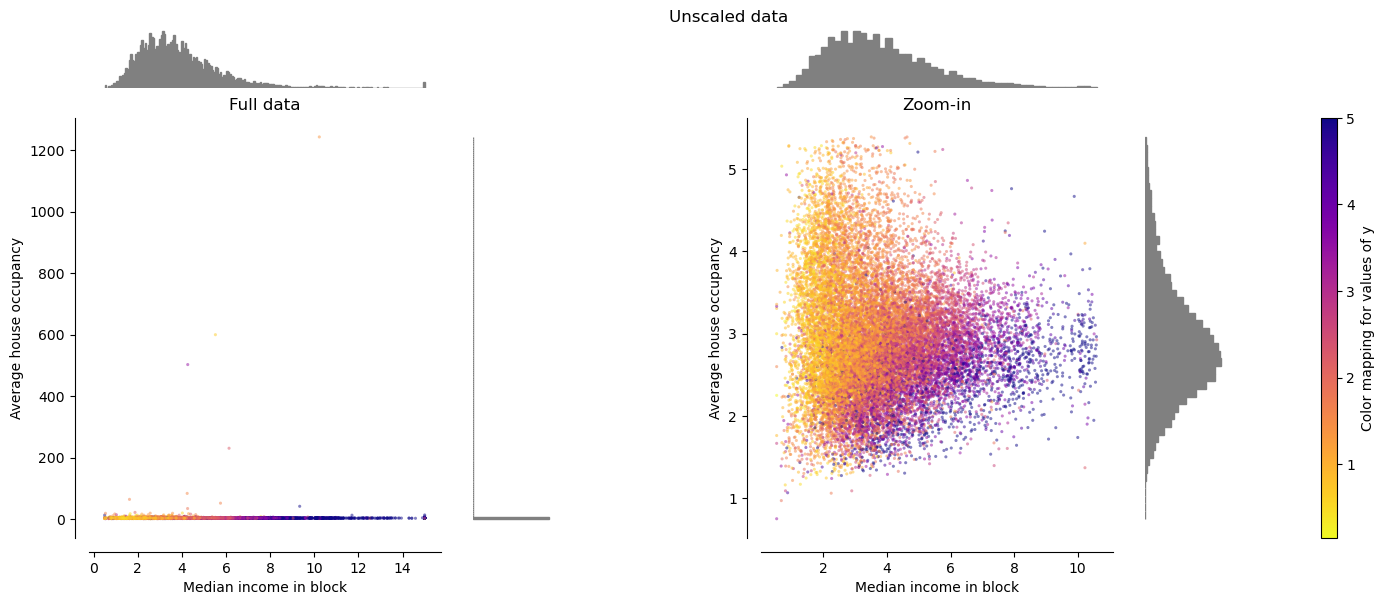

In [3]:
make_plot(0)

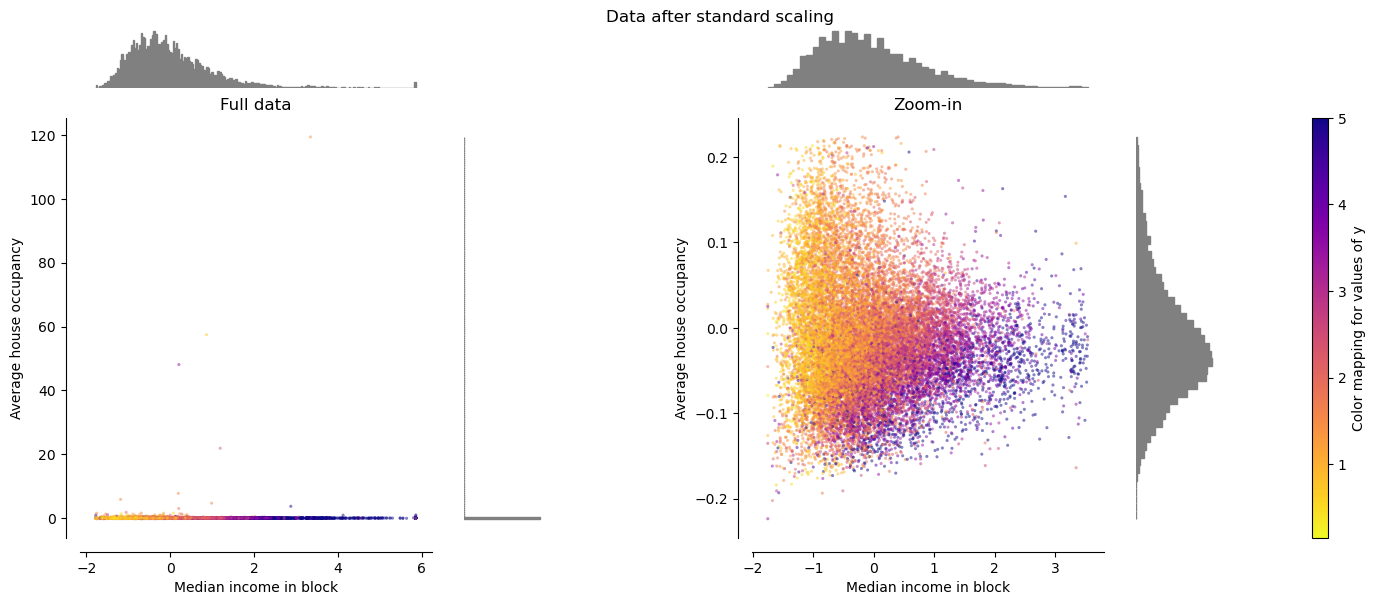

In [4]:
make_plot(1)

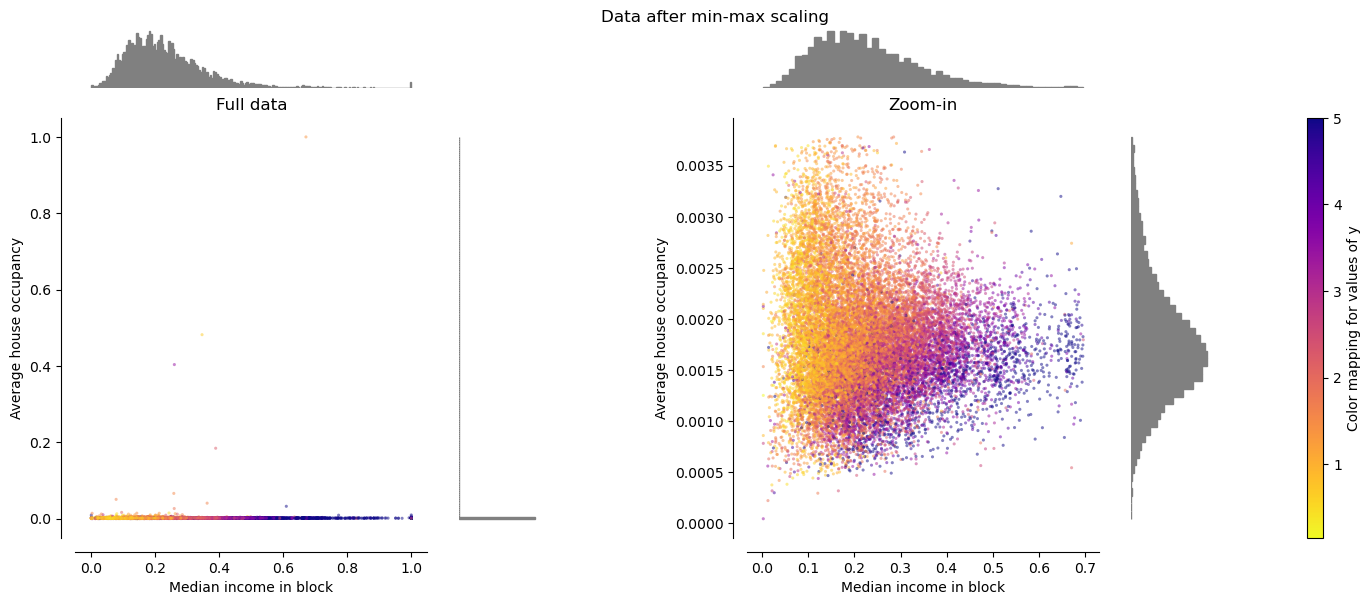

In [5]:
make_plot(2)

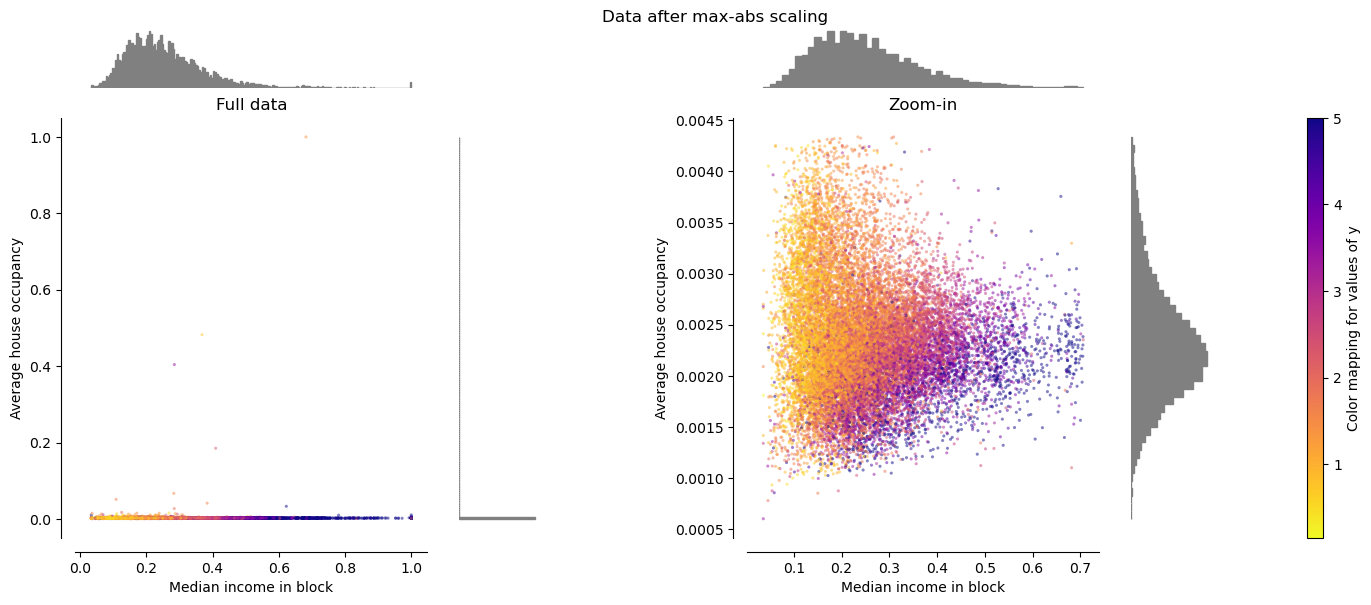

In [6]:
make_plot(3)

In [ ]:

import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

from importlib.metadata import version

print(f"Versión de Scikit-learn: {version('scikit-learn')}")
print(f"Versión de Pandas: {version('pandas')}")

modelos_grid = GridSearchCV(lasso, param_grid, cv=kfold, n_jobs=-1,verbose=2)

In [ ]:
#Orden correcto de PolynomialFeatures

X = np.array([[1], [2], [3], [4], [5], [6]])
y = np.array([1.5, 1.9, 3.2, 3.8, 5.1, 5.9])

# =========================
# Train / Test split
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =========================
# 1. Polinomial
# =========================
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)   # 👈 SOLO transform

# =========================
# 2. Escalado
# =========================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)  # 👈 SOLO transform

# =========================
# 3. Ridge
# =========================
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)

In [ ]:
# Aqui se ve el uso correco de un pipeline

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

# Datos
X = np.array([[1], [2], [3], [4], [5], [6]])
y = np.array([1.5, 1.9, 3.2, 3.8, 5.1, 5.9])

# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Pipeline: Polinomial → Escalado → Ridge
pipe = Pipeline([
    ('poly',   PolynomialFeatures(degree=3, include_bias=False)),
    ('scaler', StandardScaler()),
    ('ridge',  Ridge(alpha=1.0))
])

# Entrenar (internamente hace fit_transform en poly y scaler, fit en ridge)
pipe.fit(X_train, y_train)

# Predecir (internamente hace transform en poly y scaler, predict en ridge) No es necesario ahora hacer el poly.transform(X_test) ni el escaler
y_pred = pipe.predict(X_test)

# Evaluación
print(f"R²:  {r2_score(y_test, y_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")

In [ ]:
#otro uso correcto de pipeline pero con k-folds

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import PolynomialFeatures, RobustScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

pipe = Pipeline([
    ('poly',   PolynomialFeatures(include_bias=False)),
    ('scaler', RobustScaler()),
    ('ridge',  Ridge())
])

param_grid = {
    'poly__degree': [1, 2, 3, 4],
    'ridge__alpha': [0.01, 0.1, 1, 5, 10, 50, 100, 500]
}

kfold = KFold(n_splits=10, shuffle=True, random_state=0)

grid = GridSearchCV(pipe, param_grid, cv=kfold, scoring='r2', n_jobs=-1)
grid.fit(x_train, y_train)

print(f"Mejor grado:  {grid.best_params_['poly__degree']}")
print(f"Mejor alpha:  {grid.best_params_['ridge__alpha']}")
print(f"Mejor R² CV:  {grid.best_score_:.4f}")

# Evaluación final en test
y_pred = grid.predict(x_test)

print('\n------ Evaluación en Test ------')
print(f"RMSE: {root_mean_squared_error(y_test, y_pred):.2f}")
print(f"MAE:  {mean_absolute_error(y_test, y_pred):.2f}")
print(f"R²:   {r2_score(y_test, y_pred):.4f}")